In [1]:
import numpy as np
import pandas as pd
from random import choice
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf, linewidth=300)
np.set_printoptions(suppress=True)

In [2]:
# --------------------------------------------Data Comunas--------------------------------------------
comunas = {
"Cerrillos"          : 1,
"Cerro Navia"        : 2,
"Conchalí"           : 3,
"El Bosque"          : 4,
"Estación Central"   : 5,
"Independencia"      : 6,
"La Cisterna"        : 7,
"Lo Prado"           : 8,
"Macul"              : 9,
"Maipú"              : 10,
"Ñuñoa"              : 11,
"Pedro Aguirre Cerda": 12,
"Providencia"        : 13,
"Quinta Normal"      : 14,
"Recoleta"           : 15,
"San Joaquín"        : 16,
"San Miguel"         : 17,
"San Ramón"          : 18,
"Santiago"           : 19,
"Vitacura"           : 20,
}

adj_comunas = {
1 : (10,5,12),
2 : (8,14),
3 : (6,15),
4 : (7,18),
5 : (8,14,19,12,1,10),
6 : (3,15,19),
7 : (17,18,4),
8 : (2,14,5),
9 : (16,11),
10: (5,1),
11: (13,19,16,9),
12: (1,5,19,17),
13: (15,19,11,20),
14: (2,8,5,19),
15: (3,6,19,13,20),
16: (17,19,9,11),
17: (12,19,16,7,18),
18: (4,7,17),
19: (6,15,13,11,16,17,12,5,14),
20: (15,13),
}

# ----------------------------------------------Funciones----------------------------------------------
def markov(init, mat, n):
    simlist = np.zeros(n+1, dtype=int)
    states = list(range(len(init)))
    simlist[1] = np.random.choice(states, p=init)
    for i in range(2, n+1):
        simlist[i] = np.random.choice(states, p=mat[simlist[i - 1], :])

    return simlist[1:]

def matriz_transicion():
    with open('Data_Vehiculos.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    dict_comuna = {}

    def convertir_precio(precio_str):
        return int(precio_str.replace('.', '').replace('$', ''))

    for line in lines:
        line = line.strip()
        if line.startswith("Comuna de"):
            comuna_actual = line.replace("Comuna de ", "").strip()
            dict_comuna[comuna_actual] = []
        elif ',' in line:
            vehiculo, precio = line.rsplit(',', 1)
            vehiculo = vehiculo.strip()
            precio = convertir_precio(precio.strip())
            dict_comuna[comuna_actual].append((vehiculo, precio))

    veh_azar = {comuna: choice(dict_comuna[comuna]) for comuna in dict_comuna.keys()}
    veh_azar_num = {comunas[com]: veh_azar[com][1] for com in dict_comuna.keys()}

    pond_veh = dict() # Atractivo de cada comuna

    for k in veh_azar_num:
        indices  = adj_comunas[k] + (k,)
        suma     = sum(veh_azar_num[i] for i in indices)
        res_suma = {i: veh_azar_num[i]/suma for i in indices}
        pond_veh[k]   = res_suma

    n = len(pond_veh)

    matriz_vehiculos = np.zeros((n,n))

    for i, dic in pond_veh.items():
        for j, val in dic.items():
            matriz_vehiculos[i-1,j-1] = val

    matriz_adj = np.zeros((20,20))

    for i in adj_comunas.keys():
        matriz_adj[i-1,i-1] = 1
        for j in adj_comunas[i]:
            matriz_adj[i-1,j-1] = 1 

    df = pd.read_excel("pazciudadanacl_exportacion.xlsx")
    df_comunas = df[df["Comuna"].isin(comunas.keys())]
    # TOMAREMOS LA FREQ
    df_new = df_comunas[["Comuna","Frecuencia"]].copy()

    df_new["Proporcion"] = df_new["Frecuencia"]/df_new["Frecuencia"].sum()
    df_new.reset_index(drop=True, inplace=True) #c_bt
    # df_new

    df_new["Num_Comuna"] = df_new["Comuna"].map(comunas)
    df = df_new[["Num_Comuna", "Proporcion"]].copy()

    psi = np.zeros((n,n))

    for i in range(len(psi)):
        for j in range(len(psi)):
                psi[i,j] = ((1 - df["Proporcion"])[i]) * matriz_vehiculos[i,j]

    row_sum = psi.sum(axis=1) #row wise
    normalized_psi = psi / row_sum[:, np.newaxis]

    return normalized_psi

def estacionaria(P, mode=False): #Porque es ergodica podemos hacer esta wea 
    n = 2
    pow1 = np.linalg.matrix_power(P, n-1) 
    pow2 = np.linalg.matrix_power(P, n) 

    error = np.linalg.norm(pow2-pow1)

    while error >= 1e-7:
        pow1 = np.linalg.matrix_power(P, n-1) 
        pow2 = np.linalg.matrix_power(P, n)

        error = np.linalg.norm(pow2-pow1)

        n+=1

    idx = np.array([i for i in range(1,len(P)+1)])

    if mode:
        return pow2[0]

    res = np.column_stack((idx, np.round(pow2[0], 6)))

    return res, n

def tiempos_espera(P, j):
    Q = np.delete(P, j-1, axis=0)
    Q = np.delete(Q, j-1, axis=1)

    n_q = Q.shape[1]
    F = np.linalg.inv(np.identity(n_q) - Q)
    idx = np.array([i for i in range(1,len(P)+1) if i != j])
    sums_F = np.round(F.sum(axis=1), 3)
    res_F = np.column_stack((idx, sums_F))

    return res_F

def matriz_tiempos_espera(P):
    tiempos_esp = np.zeros((20,20))

    for com in adj_comunas.keys():
        esp = tiempos_espera(P, com)
        for idx, val in esp:
            tiempos_esp[int(idx)-1, com-1]  = val

    return tiempos_esp

def promedios(n_exp):
    prom_est   = list()
    prom_t_esp = list()

    for i in range(n_exp):
        P = matriz_transicion()
        prom_est.append(estacionaria(P, mode=1))
        prom_t_esp.append(matriz_tiempos_espera(P))

    prom_est       = np.asarray(prom_est)
    prom_t_esp     = np.asarray(prom_t_esp)
    promedio_est   = np.round(prom_est.mean(axis=0), 2)
    promedio_t_esp = np.round(prom_t_esp.mean(axis=0),2)
    return promedio_est, promedio_t_esp

def graficos(n_exp):
    prom_est   = list()
    prom_t_esp = list()

    for i in range(n_exp):
        P = matriz_transicion()
        prom_est.append(estacionaria(P, mode=1))
        prom_t_esp.append(matriz_tiempos_espera(P))

    prom_est       = np.asarray(prom_est)
    prom_t_esp     = np.asarray(prom_t_esp)

    return prom_est, prom_t_esp


In [3]:
# ------------------------------ MonteCarlo ------------------------------
P = matriz_transicion()
lista_pasos = [10, 100, 1_000, 10_000, 100_000, 1_000_000]

init = np.array([1/len(P) for i in range(len(P))])

list_paseo = list()

for pasos in lista_pasos:
    m = markov(init, P, pasos)+1
    u, n = np.unique(m, return_counts=True)
    suma = sum(n)
    freq = n/suma
    mat = np.column_stack((u,n,freq))

    print(f"Paseo comienzó en {m[0]} y terminó en {m[-1]}:")
    print(mat)
    print("\n")
    np.savetxt(f"Resultados_MonteCarlo\\{pasos}_pasos.csv", mat, delimiter=";", fmt=["%i","%i","%.3f"])

estacionaria(P)

Paseo comienzó en 8 y terminó en 14:
[[ 2.   2.   0.2]
 [ 5.   2.   0.2]
 [ 8.   1.   0.1]
 [14.   5.   0.5]]


Paseo comienzó en 6 y terminó en 19:
[[ 4.    6.    0.06]
 [ 5.    5.    0.05]
 [ 6.    2.    0.02]
 [ 7.    2.    0.02]
 [ 8.    1.    0.01]
 [ 9.    1.    0.01]
 [11.    2.    0.02]
 [12.    4.    0.04]
 [13.    3.    0.03]
 [14.    2.    0.02]
 [15.    7.    0.07]
 [16.    4.    0.04]
 [17.   11.    0.11]
 [18.   11.    0.11]
 [19.    7.    0.07]
 [20.   32.    0.32]]


Paseo comienzó en 11 y terminó en 2:
[[  1.     26.      0.026]
 [  2.     13.      0.013]
 [  3.      3.      0.003]
 [  4.     25.      0.025]
 [  5.     54.      0.054]
 [  6.     37.      0.037]
 [  7.     21.      0.021]
 [  8.     17.      0.017]
 [  9.     27.      0.027]
 [ 10.      6.      0.006]
 [ 11.     70.      0.07 ]
 [ 12.     68.      0.068]
 [ 13.     56.      0.056]
 [ 14.     27.      0.027]
 [ 15.     68.      0.068]
 [ 16.     51.      0.051]
 [ 17.     86.      0.086]
 [ 18.     79.  

(array([[ 1.      ,  0.026554],
        [ 2.      ,  0.015321],
        [ 3.      ,  0.003695],
        [ 4.      ,  0.026552],
        [ 5.      ,  0.051072],
        [ 6.      ,  0.028182],
        [ 7.      ,  0.020627],
        [ 8.      ,  0.022567],
        [ 9.      ,  0.02892 ],
        [10.      ,  0.005481],
        [11.      ,  0.071364],
        [12.      ,  0.060645],
        [13.      ,  0.049867],
        [14.      ,  0.035985],
        [15.      ,  0.070561],
        [16.      ,  0.051267],
        [17.      ,  0.077498],
        [18.      ,  0.067309],
        [19.      ,  0.044138],
        [20.      ,  0.242396]]),
 267)

In [4]:
P

array([[0.24376259, 0.        , 0.        , 0.        , 0.28668836, 0.        , 0.        , 0.        , 0.        , 0.08213234, 0.        , 0.38741671, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.28414097, 0.        , 0.        , 0.        , 0.        , 0.        , 0.29735683, 0.        , 0.        , 0.        , 0.        , 0.        , 0.4185022 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0771028 , 0.        , 0.        , 0.49065421, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.43224299, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.30172414, 0.        , 0.        , 0.1637931 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.53448276, 0.        , 0.        ],
    

In [5]:
matriz_tiempos_espera(P)

array([[  0.   , 143.969, 353.368, 110.582,  17.775,  95.005,  95.187,  88.743,  77.792, 202.774,  43.36 ,   9.136,  56.441,  60.097,  60.175,  40.352,  24.646,  61.563,  21.076,  60.82 ],
       [ 60.301,   0.   , 353.848, 120.052,  15.305,  95.288, 104.657,  32.114,  81.234, 229.15 ,  46.079,  25.874,  57.617,  10.033,  60.878,  44.943,  34.117,  71.034,  20.369,  61.713],
       [106.917, 191.065,   0.   , 139.552,  75.164,  27.095, 124.158, 138.819,  79.832, 282.923,  40.94 ,  61.172,  23.95 , 105.074,   8.926,  49.481,  53.617,  90.534,  27.729,  17.134],
       [ 82.4  , 175.538, 357.822,   0.   ,  55.462,  99.968,  38.54 , 122.083,  74.554, 261.008,  41.998,  32.54 ,  59.088,  90.407,  64.049,  34.131,   5.755,   4.917,  28.609,  64.199],
       [ 48.206, 129.404, 352.047, 114.075,   0.   ,  93.578,  98.68 ,  73.249,  78.056, 215.319,  43.237,  16.521,  55.492,  46.192,  58.973,  41.232,  28.139,  65.056,  19.119,  59.719],
       [103.044, 186.995, 281.585, 136.189,  71.186,   

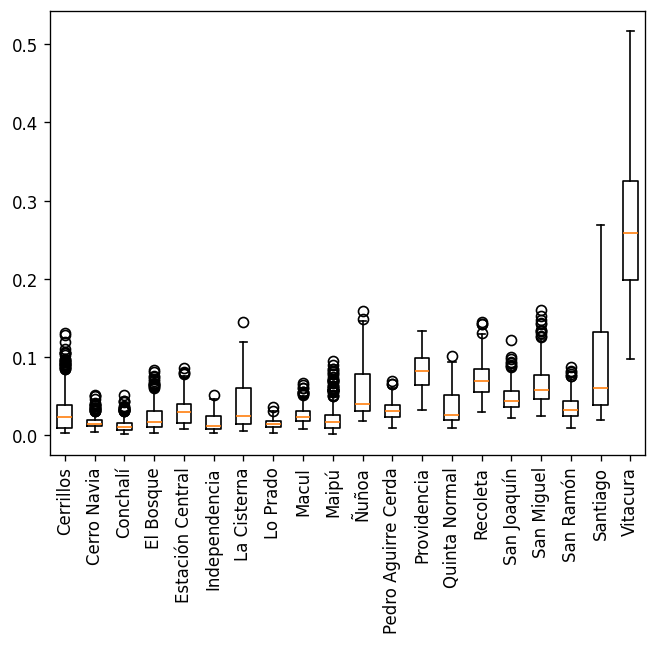

In [6]:
prom_est, _ = graficos(400)

fig, ax = plt.subplots(dpi = 120) 

ax.boxplot(prom_est , tick_labels=list(comunas.keys()))

plt.xticks(rotation=90)

plt.show()